# AIFFEL Kaggle 1

---

## Import

In [2]:
import numpy as np
import pandas as pd
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 100)

from itertools import product
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from xgboost import XGBRegressor
from xgboost import plot_importance

def plot_features(booster, figsize):    
    fig, ax = plt.subplots(1,1,figsize=figsize)
    return plot_importance(booster=booster, ax=ax)

import time
import sys
import gc
import pickle

sys.version_info

sys.version_info(major=3, minor=7, micro=6, releaselevel='final', serial=0)

In [2]:
items = pd.read_csv('../data/items.csv')
shops = pd.read_csv('../data/shops.csv')
cats = pd.read_csv('../data/item_categories.csv')
train = pd.read_csv('../data/sales_train.csv')
test  = pd.read_csv('../data/test.csv')

## EDA

### Outliers

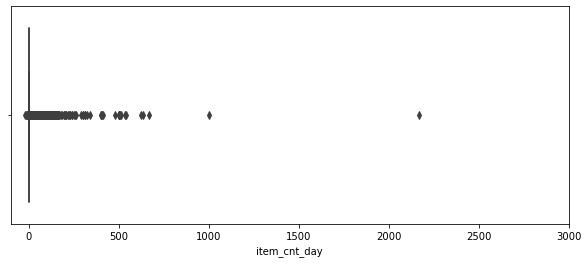

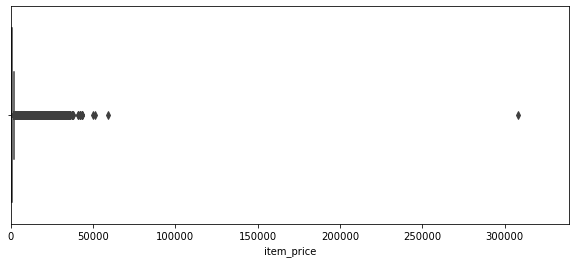

In [3]:
plt.figure(figsize=(10,4))
plt.xlim(-100, 3000)
sns.boxplot(x=train.item_cnt_day)

plt.figure(figsize=(10,4))
plt.xlim(train.item_price.min(), train.item_price.max()*1.1)
sns.boxplot(x=train.item_price)

In [4]:
train = train[train.item_price<300000]
train = train[train.item_cnt_day<1000]

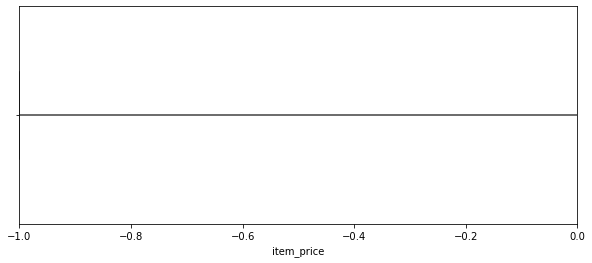

In [5]:
# 아이템 가격이 0 보다 작은 것들 존재
plt.figure(figsize=(10,4))
plt.xlim(train.item_price.min(), 0)
sns.boxplot(x=train.item_price)

In [6]:
# 아이템 가격 0보다 작은것들 중간값을 바꿔준다.
train = train[train.item_price>0].reset_index(drop=True)
train.loc[train.item_cnt_day < 1, "item_cnt_day"] = 0

In [7]:
# 가게 아이디와 가게 이름이 맞지않는 데이터 처리
# Якутск Орджоникидзе, 56
train.loc[train.shop_id == 0, 'shop_id'] = 57
test.loc[test.shop_id == 0, 'shop_id'] = 57
# Якутск ТЦ "Центральный"
train.loc[train.shop_id == 1, 'shop_id'] = 58
test.loc[test.shop_id == 1, 'shop_id'] = 58
# Жуковский ул. Чкалова 39м²
train.loc[train.shop_id == 10, 'shop_id'] = 11
test.loc[test.shop_id == 10, 'shop_id'] = 11

## Data Preprocessing

### Shops/Cats/Items preprocessing

In [8]:
# 가게이름에서 첫번째 단어는 도시이름
shops.head()

,shop_name,shop_id
0,"!Якутск Орджоникидзе, 56 фран",0
1,"!Якутск ТЦ ""Центральный"" фран",1
2,"Адыгея ТЦ ""Мега""",2
3,"Балашиха ТРК ""Октябрь-Киномир""",3
4,"Волжский ТЦ ""Волга Молл""",4


In [9]:
# 가게이름 통일시켜주기
shops.loc[shops.shop_name == 'Сергиев Посад ТЦ "7Я"', 'shop_name'] = 'СергиевПосад ТЦ "7Я"'
# 도시이름 뽑아내기
shops['city'] = shops['shop_name'].str.split(' ').map(lambda x: x[0])
shops["category"] = shops.shop_name.str.split(" ").map( lambda x: x[1] )
shops.loc[shops.city == "!Якутск", "city"] = "Якутск"
# # city를 encoding 해서 새로운 feature 만들기
# shops['city_code'] = LabelEncoder().fit_transform(shops['city'])
# shops = shops[['shop_id','city_code']]



In [10]:
category = []
for cat in shops.category.unique():
    if len(shops[shops.category == cat]) >= 5:
        category.append(cat)
shops.category = shops.category.apply( lambda x: x if (x in category) else "other" )

In [11]:
from sklearn.preprocessing import LabelEncoder
shops["shop_category"] = LabelEncoder().fit_transform( shops.category )
shops["shop_city"] = LabelEncoder().fit_transform( shops.city )
shops = shops[["shop_id", "shop_category", "shop_city"]]

In [12]:
cats["type_code"] = cats.item_category_name.apply( lambda x: x.split(" ")[0] ).astype(str)
cats.loc[ (cats.type_code == "Игровые")| (cats.type_code == "Аксессуары"), "category" ] = "Игры"

In [13]:
category = []
for cat in cats.type_code.unique():
    if len(cats[cats.type_code == cat]) >= 5: 
        category.append( cat )
cats.type_code = cats.type_code.apply(lambda x: x if (x in category) else "etc")


In [14]:
cats.type_code = LabelEncoder().fit_transform(cats.type_code)
cats["split"] = cats.item_category_name.apply(lambda x: x.split("-"))
cats["subtype"] = cats.split.apply(lambda x: x[1].strip() if len(x) > 1 else x[0].strip())
cats["subtype_code"] = LabelEncoder().fit_transform( cats["subtype"] )
cats = cats[["item_category_id", "subtype_code", "type_code"]]

In [15]:
# 메인 카테고리, 서브 카테고리로 구성되어있다.
cats.head()

,item_category_id,subtype_code,type_code
0,0,29,0
1,1,9,1
2,2,10,1
3,3,11,1
4,4,13,1


In [16]:
# cats['split'] = cats['item_category_name'].str.split('-')
# cats['type'] = cats['split'].map(lambda x: x[0].strip())
# cats['type_code'] = LabelEncoder().fit_transform(cats['type'])
# # if subtype is nan then type
# cats['subtype'] = cats['split'].map(lambda x: x[1].strip() if len(x) > 1 else x[0].strip())
# cats['subtype_code'] = LabelEncoder().fit_transform(cats['subtype'])
# cats = cats[['item_category_id','type_code', 'subtype_code']]

# # 아이템 이름 삭제
# items.drop(['item_name'], axis=1, inplace=True)

### Item

In [17]:
import re
def name_correction(x):
    x = x.lower() # all letters lower case
    x = x.partition('[')[0] # partition by square brackets
    x = x.partition('(')[0] # partition by curly brackets
    x = re.sub('[^A-Za-z0-9А-Яа-я]+', ' ', x) # remove special characters
    x = x.replace('  ', ' ') # replace double spaces with single spaces
    x = x.strip() # remove leading and trailing white space
    return x

In [18]:
# split item names by first bracket
items["name1"], items["name2"] = items.item_name.str.split("[", 1).str
items["name1"], items["name3"] = items.item_name.str.split("(", 1).str

# replace special characters and turn to lower case
items["name2"] = items.name2.str.replace('[^A-Za-z0-9А-Яа-я]+', " ").str.lower()
items["name3"] = items.name3.str.replace('[^A-Za-z0-9А-Яа-я]+', " ").str.lower()

# fill nulls with '0'
items = items.fillna('0')

items["item_name"] = items["item_name"].apply(lambda x: name_correction(x))

# return all characters except the last if name 2 is not "0" - the closing bracket
items.name2 = items.name2.apply( lambda x: x[:-1] if x !="0" else "0")

/home/aiffel0046/anaconda3/envs/aiffel/lib/python3.7/site-packages/ipykernel_launcher.py:2: FutureWarning: Columnar iteration over characters will be deprecated in future releases.
  
/home/aiffel0046/anaconda3/envs/aiffel/lib/python3.7/site-packages/ipykernel_launcher.py:3: FutureWarning: Columnar iteration over characters will be deprecated in future releases.
  This is separate from the ipykernel package so we can avoid doing imports until


In [19]:
items["type"] = items.name2.apply(lambda x: x[0:8] if x.split(" ")[0] == "xbox" else x.split(" ")[0] )
items.loc[(items.type == "x360") | (items.type == "xbox360") | (items.type == "xbox 360") ,"type"] = "xbox 360"
items.loc[ items.type == "", "type"] = "mac"
items.type = items.type.apply( lambda x: x.replace(" ", "") )
items.loc[ (items.type == 'pc' )| (items.type == 'pс') | (items.type == "pc"), "type" ] = "pc"
items.loc[ items.type == 'рs3' , "type"] = "ps3"

In [20]:
group_sum = items.groupby(["type"]).agg({"item_id": "count"})
group_sum = group_sum.reset_index()
drop_cols = []
for cat in group_sum.type.unique():
    if group_sum.loc[(group_sum.type == cat), "item_id"].values[0] <40:
        drop_cols.append(cat)
items.name2 = items.name2.apply( lambda x: "other" if (x in drop_cols) else x )
items = items.drop(["type"], axis = 1)

In [21]:
items.name2 = LabelEncoder().fit_transform(items.name2)
items.name3 = LabelEncoder().fit_transform(items.name3)

items.drop(["item_name", "name1"],axis = 1, inplace= True)
items.head()


,item_id,item_category_id,name2,name3
0,0,40,4,1331
1,1,76,64,42
2,2,40,4,1011
3,3,40,4,1010
4,4,40,4,1572


In [22]:
# from itertools import product
# import time
# ts = time.time()
# matrix = []
# cols  = ["date_block_num", "shop_id", "item_id"]
# for i in range(34):
#     sales = train[train.date_block_num == i]
#     matrix.append( np.array(list( product( [i], sales.shop_id.unique(), sales.item_id.unique() ) ), dtype = np.int16) )

# matrix = pd.DataFrame( np.vstack(matrix), columns = cols )
# matrix["date_block_num"] = matrix["date_block_num"].astype(np.int8)
# matrix["shop_id"] = matrix["shop_id"].astype(np.int8)
# matrix["item_id"] = matrix["item_id"].astype(np.int16)
# matrix.sort_values( cols, inplace = True )
# time.time()- ts

### Monthly sales

In [23]:
# 예측해야하는 달(34)의 가게+아이템
test.head()

,ID,shop_id,item_id
0,0,5,5037
1,1,5,5320
2,2,5,5233
3,3,5,5232
4,4,5,5268


In [24]:
# train에는 없고 test에만 있는 아이템 확인
len(list(set(test.item_id) - set(test.item_id).intersection(set(train.item_id)))), len(list(set(test.item_id))), len(test)

(363, 5100, 214200)

In [25]:
# (월, 가게, 아이템) 데이터프레임을 모든 경우를 조합해서 만든다.
ts = time.time()
matrix = []
cols = ['date_block_num','shop_id','item_id']
for i in range(34):
    sales = train[train.date_block_num==i]
    matrix.append(np.array(list(product([i], sales.shop_id.unique(), sales.item_id.unique())), dtype='int16'))
    
matrix = pd.DataFrame(np.vstack(matrix), columns=cols)
matrix['date_block_num'] = matrix['date_block_num'].astype(np.int8)
matrix['shop_id'] = matrix['shop_id'].astype(np.int8)
matrix['item_id'] = matrix['item_id'].astype(np.int16)
matrix.sort_values(cols,inplace=True)
time.time() - ts

6.345926284790039

In [26]:
matrix.head()

,date_block_num,shop_id,item_id
114910,0,2,19
117150,0,2,27
120623,0,2,28
118316,0,2,29
114602,0,2,32


In [27]:
train['revenue'] = train['item_price'] *  train['item_cnt_day']

In [28]:
# 월별 판매량 0~20, 결측치는 0
ts = time.time()
group = train.groupby(['date_block_num','shop_id','item_id']).agg({'item_cnt_day': ['sum']})
group.columns = ['item_cnt_month']
group.reset_index(inplace=True)

matrix = pd.merge(matrix, group, on=cols, how='left')
matrix['item_cnt_month'] = (matrix['item_cnt_month']
                                .fillna(0)
                                .astype(np.float16))
time.time() - ts

2.531782865524292

In [29]:
matrix.head()

,date_block_num,shop_id,item_id,item_cnt_month
0,0,2,19,0.0
1,0,2,27,1.0
2,0,2,28,0.0
3,0,2,29,0.0
4,0,2,32,0.0


### Test set

In [30]:
# test에도 똑같이 적용시켜준다.
test['date_block_num'] = 34
test['date_block_num'] = test['date_block_num'].astype(np.int8)
test['shop_id'] = test['shop_id'].astype(np.int8)
test['item_id'] = test['item_id'].astype(np.int16)

In [31]:
test.head()

,ID,shop_id,item_id,date_block_num
0,0,5,5037,34
1,1,5,5320,34
2,2,5,5233,34
3,3,5,5232,34
4,4,5,5268,34


In [32]:
# matrix = train + test
ts = time.time()
# matrix = pd.concat([matrix, test], ignore_index=True, sort=False, keys=cols)
matrix = pd.concat([matrix, test.drop(["ID"],axis = 1)], ignore_index=True, sort=False, keys=cols)
matrix.fillna(0, inplace=True) # 34 month
time.time() - ts

0.036423444747924805

In [33]:
matrix.head()

,date_block_num,shop_id,item_id,item_cnt_month
0,0,2,19,0.0
1,0,2,27,1.0
2,0,2,28,0.0
3,0,2,29,0.0
4,0,2,32,0.0


In [34]:
matrix.tail()

,date_block_num,shop_id,item_id,item_cnt_month
11127999,34,45,18454,0.0
11128000,34,45,16188,0.0
11128001,34,45,15757,0.0
11128002,34,45,19648,0.0
11128003,34,45,969,0.0


### Shops/Items/Cats features

In [35]:
# # 이전에 만들었던 feature들을 matrix에 넣어준다. (item_category_id, city_code, type_code, subtype_code)
# ts = time.time()
# matrix = pd.merge(matrix, shops, on=['shop_id'], how='left')
# matrix = pd.merge(matrix, items, on=['item_id'], how='left')
# matrix = pd.merge(matrix, cats, on=['item_category_id'], how='left')
# matrix['city_code'] = matrix['city_code'].astype(np.int8)
# matrix['item_category_id'] = matrix['item_category_id'].astype(np.int8)
# matrix['type_code'] = matrix['type_code'].astype(np.int8)
# matrix['subtype_code'] = matrix['subtype_code'].astype(np.int8)
# time.time() - ts
ts = time.time()
matrix = pd.merge( matrix, shops, on = ["shop_id"], how = "left" )
matrix = pd.merge(matrix, items, on = ["item_id"], how = "left")
matrix = pd.merge( matrix, cats, on = ["item_category_id"], how = "left" )
matrix["shop_city"] = matrix["shop_city"].astype(np.int8)
matrix["shop_category"] = matrix["shop_category"].astype(np.int8)
matrix["item_category_id"] = matrix["item_category_id"].astype(np.int8)
matrix["subtype_code"] = matrix["subtype_code"].astype(np.int8)
matrix["name2"] = matrix["name2"].astype(np.int8)
matrix["name3"] = matrix["name3"].astype(np.int16)
matrix["type_code"] = matrix["type_code"].astype(np.int8)
time.time() - ts

2.2654869556427

### Traget lags

In [36]:
# lag : 이전 달들의 판매량
# def lag_feature(df, lags, col):
#     tmp = df[['date_block_num','shop_id','item_id',col]]
#     for i in lags:
#         shifted = tmp.copy()
#         shifted.columns = ['date_block_num','shop_id','item_id', col+'_lag_'+str(i)]
#         shifted['date_block_num'] += i
#         df = pd.merge(df, shifted, on=['date_block_num','shop_id','item_id'], how='left')
#     return df
def lag_feature( df,lags, cols ):
    for col in cols:
        print(col)
        tmp = df[["date_block_num", "shop_id","item_id",col ]]
        for i in lags:
            shifted = tmp.copy()
            shifted.columns = ["date_block_num", "shop_id", "item_id", col + "_lag_"+str(i)]
            shifted.date_block_num = shifted.date_block_num + i
            df = pd.merge(df, shifted, on=['date_block_num','shop_id','item_id'], how='left')
    return df

In [37]:
ts = time.time()
# matrix = lag_feature(matrix, [1,2,3,6,12], 'item_cnt_month')
matrix = lag_feature( matrix, [1,2,3], ["item_cnt_month"] )
time.time() - ts

item_cnt_month


9.62947702407837

In [26]:
matrix.head()

,date_block_num,shop_id,item_id,item_cnt_month,city_code,item_category_id,type_code,subtype_code,item_cnt_month_lag_1,item_cnt_month_lag_2,item_cnt_month_lag_3,item_cnt_month_lag_6,item_cnt_month_lag_12
0,0,2,19,0.0,0,40,11,4,NaN,NaN,NaN,NaN,NaN
1,0,2,27,1.0,0,19,5,10,NaN,NaN,NaN,NaN,NaN
2,0,2,28,0.0,0,30,8,55,NaN,NaN,NaN,NaN,NaN
3,0,2,29,0.0,0,23,5,16,NaN,NaN,NaN,NaN,NaN
4,0,2,32,0.0,0,40,11,4,NaN,NaN,NaN,NaN,NaN


### Mean encoded features

In [41]:
# 월별 팔린 평균 아이템 갯수, lag
# ts = time.time()
# group = matrix.groupby(['date_block_num']).agg({'item_cnt_month': ['mean']})
# group.columns = [ 'date_avg_item_cnt' ]
# group.reset_index(inplace=True)

# matrix = pd.merge(matrix, group, on=['date_block_num'], how='left')
# matrix['date_avg_item_cnt'] = matrix['date_avg_item_cnt'].astype(np.float16)
# matrix = lag_feature(matrix, [1], 'date_avg_item_cnt')
# matrix.drop(['date_avg_item_cnt'], axis=1, inplace=True)
# time.time() - ts
ts = time.time()
group = matrix.groupby( ["date_block_num"] ).agg({"item_cnt_month" : ["mean"]})
group.columns = ["date_avg_item_cnt"]
group.reset_index(inplace = True)

matrix = pd.merge(matrix, group, on = ["date_block_num"], how = "left")
matrix["date_avg_item_cnt"] = matrix["date_avg_item_cnt"].astype(np.float16)
matrix = lag_feature( matrix, [1], ["date_avg_item_cnt"] )
matrix.drop( ["date_avg_item_cnt"], axis = 1, inplace = True )
time.time() - ts

date_avg_item_cnt


6.042592763900757

In [44]:
# # 월별의 아이템별 팔린 평균 갯수, lag
# ts = time.time()
# group = matrix.groupby(['date_block_num', 'item_id']).agg({'item_cnt_month': ['mean']})
# group.columns = [ 'date_item_avg_item_cnt' ]
# group.reset_index(inplace=True)

# matrix = pd.merge(matrix, group, on=['date_block_num','item_id'], how='left')
# matrix['date_item_avg_item_cnt'] = matrix['date_item_avg_item_cnt'].astype(np.float16)
# matrix = lag_feature(matrix, [1,2,3], ['date_item_avg_item_cnt'])
# matrix.drop(['date_item_avg_item_cnt'], axis=1, inplace=True)
# time.time() - ts
ts = time.time()
group = matrix.groupby(['date_block_num', 'item_id']).agg({'item_cnt_month': ['mean']})
group.columns = [ 'date_item_avg_item_cnt' ]
group.reset_index(inplace=True)

matrix = pd.merge(matrix, group, on=['date_block_num','item_id'], how='left')
matrix.date_item_avg_item_cnt = matrix['date_item_avg_item_cnt'].astype(np.float16)
matrix = lag_feature(matrix, [1,2,3], ['date_item_avg_item_cnt'])
matrix.drop(['date_item_avg_item_cnt'], axis=1, inplace=True)
time.time() - ts

date_item_avg_item_cnt


13.68004059791565

In [47]:
# # 월별의 가게에서 팔린 평균 아이템 갯수, lag
# ts = time.time()
# group = matrix.groupby(['date_block_num', 'shop_id']).agg({'item_cnt_month': ['mean']})
# group.columns = [ 'date_shop_avg_item_cnt' ]
# group.reset_index(inplace=True)

# matrix = pd.merge(matrix, group, on=['date_block_num','shop_id'], how='left')
# matrix.date_shop_avg_item_cnt = matrix['date_shop_avg_item_cnt'].astype(np.float16)
# matrix = lag_feature(matrix, [1,2,3], 'date_shop_avg_item_cnt')
# matrix.drop(['date_shop_avg_item_cnt'], axis=1, inplace=True)
# time.time() - ts
ts = time.time()
group = matrix.groupby( ["date_block_num","shop_id"] ).agg({"item_cnt_month" : ["mean"]})
group.columns = ["date_shop_avg_item_cnt"]
group.reset_index(inplace = True)

matrix = pd.merge(matrix, group, on = ["date_block_num","shop_id"], how = "left")
matrix.date_avg_item_cnt = matrix["date_shop_avg_item_cnt"].astype(np.float16)
matrix = lag_feature( matrix, [1,2,3], ["date_shop_avg_item_cnt"] )
matrix.drop( ["date_shop_avg_item_cnt"], axis = 1, inplace = True )
time.time() - ts

/home/aiffel0046/anaconda3/envs/aiffel/lib/python3.7/site-packages/ipykernel_launcher.py:18: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access


date_shop_avg_item_cnt


13.957337379455566

In [48]:
# # 웗별의 카테고리 별 팔린 아이템 평균 갯수, lag
# ts = time.time()
# group = matrix.groupby(['date_block_num', 'item_category_id']).agg({'item_cnt_month': ['mean']})
# group.columns = [ 'date_cat_avg_item_cnt' ]
# group.reset_index(inplace=True)

# matrix = pd.merge(matrix, group, on=['date_block_num','item_category_id'], how='left')
# matrix['date_cat_avg_item_cnt'] = matrix['date_cat_avg_item_cnt'].astype(np.float16)
# matrix = lag_feature(matrix, [1], 'date_cat_avg_item_cnt')
# matrix.drop(['date_cat_avg_item_cnt'], axis=1, inplace=True)
# time.time() - ts
ts = time.time()
group = matrix.groupby( ["date_block_num","shop_id","item_id"] ).agg({"item_cnt_month" : ["mean"]})
group.columns = ["date_shop_item_avg_item_cnt"]
group.reset_index(inplace = True)

matrix = pd.merge(matrix, group, on = ["date_block_num","shop_id","item_id"], how = "left")
matrix.date_avg_item_cnt = matrix["date_shop_item_avg_item_cnt"].astype(np.float16)
matrix = lag_feature( matrix, [1,2,3], ["date_shop_item_avg_item_cnt"] )
matrix.drop( ["date_shop_item_avg_item_cnt"], axis = 1, inplace = True )
time.time() - ts

/home/aiffel0046/anaconda3/envs/aiffel/lib/python3.7/site-packages/ipykernel_launcher.py:18: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access


date_shop_item_avg_item_cnt


19.61537265777588

In [49]:
# # 월별, 각 상점에서 카테고리 별 팔린 아이템 평균 갯수, lag
# ts = time.time()
# group = matrix.groupby(['date_block_num', 'shop_id', 'item_category_id']).agg({'item_cnt_month': ['mean']})
# group.columns = ['date_shop_cat_avg_item_cnt']
# group.reset_index(inplace=True)

# matrix = pd.merge(matrix, group, on=['date_block_num', 'shop_id', 'item_category_id'], how='left')
# matrix['date_shop_cat_avg_item_cnt'] = matrix['date_shop_cat_avg_item_cnt'].astype(np.float16)
# matrix = lag_feature(matrix, [1], 'date_shop_cat_avg_item_cnt')
# matrix.drop(['date_shop_cat_avg_item_cnt'], axis=1, inplace=True)
# time.time() - ts
ts = time.time()
group = matrix.groupby(['date_block_num', 'shop_id', 'subtype_code']).agg({'item_cnt_month': ['mean']})
group.columns = ['date_shop_subtype_avg_item_cnt']
group.reset_index(inplace=True)

matrix = pd.merge(matrix, group, on=['date_block_num', 'shop_id', 'subtype_code'], how='left')
matrix.date_shop_subtype_avg_item_cnt = matrix['date_shop_subtype_avg_item_cnt'].astype(np.float16)
matrix = lag_feature(matrix, [1], ['date_shop_subtype_avg_item_cnt'])
matrix.drop(['date_shop_subtype_avg_item_cnt'], axis=1, inplace=True)
time.time() - ts

date_shop_subtype_avg_item_cnt


7.633474588394165

In [50]:
# # 월별 , 가게별 메인카테고리별 팔린 아이템 평균 갯수, lag
# ts = time.time()
# group = matrix.groupby(['date_block_num', 'shop_id', 'type_code']).agg({'item_cnt_month': ['mean']})
# group.columns = ['date_shop_type_avg_item_cnt']
# group.reset_index(inplace=True)

# matrix = pd.merge(matrix, group, on=['date_block_num', 'shop_id', 'type_code'], how='left')
# matrix['date_shop_type_avg_item_cnt'] = matrix['date_shop_type_avg_item_cnt'].astype(np.float16)
# matrix = lag_feature(matrix, [1], 'date_shop_type_avg_item_cnt')
# matrix.drop(['date_shop_type_avg_item_cnt'], axis=1, inplace=True)
# time.time() - ts
ts = time.time()
group = matrix.groupby(['date_block_num', 'shop_city']).agg({'item_cnt_month': ['mean']})
group.columns = ['date_city_avg_item_cnt']
group.reset_index(inplace=True)

matrix = pd.merge(matrix, group, on=['date_block_num', "shop_city"], how='left')
matrix.date_city_avg_item_cnt = matrix['date_city_avg_item_cnt'].astype(np.float16)
matrix = lag_feature(matrix, [1], ['date_city_avg_item_cnt'])
matrix.drop(['date_city_avg_item_cnt'], axis=1, inplace=True)
time.time() - ts

date_city_avg_item_cnt


7.87344765663147

In [51]:
# # # 월별 , 가게별 서브카테고리별 팔린 아이템 평균 갯수, lag
# ts = time.time()
# group = matrix.groupby(['date_block_num', 'shop_id', 'subtype_code']).agg({'item_cnt_month': ['mean']})
# group.columns = ['date_shop_subtype_avg_item_cnt']
# group.reset_index(inplace=True)

# matrix = pd.merge(matrix, group, on=['date_block_num', 'shop_id', 'subtype_code'], how='left')
# matrix['date_shop_subtype_avg_item_cnt'] = matrix['date_shop_subtype_avg_item_cnt'].astype(np.float16)
# matrix = lag_feature(matrix, [1], 'date_shop_subtype_avg_item_cnt')
# matrix.drop(['date_shop_subtype_avg_item_cnt'], axis=1, inplace=True)
# time.time() - ts
ts = time.time()
group = matrix.groupby(['date_block_num', 'item_id', 'shop_city']).agg({'item_cnt_month': ['mean']})
group.columns = [ 'date_item_city_avg_item_cnt' ]
group.reset_index(inplace=True)

matrix = pd.merge(matrix, group, on=['date_block_num', 'item_id', 'shop_city'], how='left')
matrix.date_item_city_avg_item_cnt = matrix['date_item_city_avg_item_cnt'].astype(np.float16)
matrix = lag_feature(matrix, [1], ['date_item_city_avg_item_cnt'])
matrix.drop(['date_item_city_avg_item_cnt'], axis=1, inplace=True)
time.time() - ts

date_item_city_avg_item_cnt


12.255043268203735

In [34]:
# # 월별 도시별 팔린 아이템 평균 갯수, lag
# ts = time.time()
# group = matrix.groupby(['date_block_num', 'city_code']).agg({'item_cnt_month': ['mean']})
# group.columns = [ 'date_city_avg_item_cnt' ]
# group.reset_index(inplace=True)

# matrix = pd.merge(matrix, group, on=['date_block_num', 'city_code'], how='left')
# matrix['date_city_avg_item_cnt'] = matrix['date_city_avg_item_cnt'].astype(np.float16)
# matrix = lag_feature(matrix, [1], 'date_city_avg_item_cnt')
# matrix.drop(['date_city_avg_item_cnt'], axis=1, inplace=True)
# time.time() - ts

7.759851455688477

In [35]:
# # 월별 아이템, 도시 단위 평균 아이템 팔린 갯수, lag
# ts = time.time()
# group = matrix.groupby(['date_block_num', 'item_id', 'city_code']).agg({'item_cnt_month': ['mean']})
# group.columns = [ 'date_item_city_avg_item_cnt' ]
# group.reset_index(inplace=True)

# matrix = pd.merge(matrix, group, on=['date_block_num', 'item_id', 'city_code'], how='left')
# matrix['date_item_city_avg_item_cnt'] = matrix['date_item_city_avg_item_cnt'].astype(np.float16)
# matrix = lag_feature(matrix, [1], 'date_item_city_avg_item_cnt')
# matrix.drop(['date_item_city_avg_item_cnt'], axis=1, inplace=True)
# time.time() - ts

12.511372804641724

In [36]:
# # 월별 메인카테고리별 팔린 아이템 평균 갯수, lag
# ts = time.time()
# group = matrix.groupby(['date_block_num', 'type_code']).agg({'item_cnt_month': ['mean']})
# group.columns = [ 'date_type_avg_item_cnt' ]
# group.reset_index(inplace=True)

# matrix = pd.merge(matrix, group, on=['date_block_num', 'type_code'], how='left')
# matrix['date_type_avg_item_cnt'] = matrix['date_type_avg_item_cnt'].astype(np.float16)
# matrix = lag_feature(matrix, [1], 'date_type_avg_item_cnt')
# matrix.drop(['date_type_avg_item_cnt'], axis=1, inplace=True)
# time.time() - ts

8.264768362045288

In [37]:
# # 월별 서브카테고리별 팔린 아이템 평균 갯수, lag
# ts = time.time()
# group = matrix.groupby(['date_block_num', 'subtype_code']).agg({'item_cnt_month': ['mean']})
# group.columns = [ 'date_subtype_avg_item_cnt' ]
# group.reset_index(inplace=True)

# matrix = pd.merge(matrix, group, on=['date_block_num', 'subtype_code'], how='left')
# matrix['date_subtype_avg_item_cnt'] = matrix['date_subtype_avg_item_cnt'].astype(np.float16)
# matrix = lag_feature(matrix, [1], 'date_subtype_avg_item_cnt')
# matrix.drop(['date_subtype_avg_item_cnt'], axis=1, inplace=True)
# time.time() - ts

8.303122758865356

### Trend features

In [52]:
# # 현재 달 기준, 지난 달의 특정 feature의 값이 전체 평균보다 높은지 낮은지 판단
# # 지난달의 값이 없을 경우 최대 6개월 전까지 확인

# ts = time.time()
# # 전 기간동안 각 아이템 평균가격
# group = train.groupby(['item_id']).agg({'item_price': ['mean']})
# group.columns = ['item_avg_item_price']
# group.reset_index(inplace=True)

# matrix = pd.merge(matrix, group, on=['item_id'], how='left')
# matrix['item_avg_item_price'] = matrix['item_avg_item_price'].astype(np.float16)

# # 월별 아이템 평균가격
# group = train.groupby(['date_block_num','item_id']).agg({'item_price': ['mean']})
# group.columns = ['date_item_avg_item_price']
# group.reset_index(inplace=True)

# matrix = pd.merge(matrix, group, on=['date_block_num','item_id'], how='left')
# matrix['date_item_avg_item_price'] = matrix['date_item_avg_item_price'].astype(np.float16)

# # 월별 각 1~6개월 전 평균 가격
# lags = [1,2,3,4,5,6]
# matrix = lag_feature(matrix, lags, 'date_item_avg_item_price')

# # 월별 (1~6)평균가격과 전체 기간 평균 각격 차이
# for i in lags:
#     matrix['delta_price_lag_'+str(i)] = \
#         (matrix['date_item_avg_item_price_lag_'+str(i)] - matrix['item_avg_item_price']) / matrix['item_avg_item_price']

# # 현재 달 기준 최근의 트렌드 찾는다.
# # 1달전 없을 경우, 최대 6달전 까지 찾는다.
# def select_trend(row):
#     for i in lags:
#         if row['delta_price_lag_'+str(i)]:
#             return row['delta_price_lag_'+str(i)]
#     return 0
    
# matrix['delta_price_lag'] = matrix.apply(select_trend, axis=1)
# matrix['delta_price_lag'] = matrix['delta_price_lag'].astype(np.float16)
# matrix['delta_price_lag'].fillna(0, inplace=True)


# # price trend를 찾은 후에는, 이전 lag들 drop
# fetures_to_drop = ['item_avg_item_price', 'date_item_avg_item_price']
# for i in lags:
#     fetures_to_drop += ['date_item_avg_item_price_lag_'+str(i)]
#     fetures_to_drop += ['delta_price_lag_'+str(i)]

# matrix.drop(fetures_to_drop, axis=1, inplace=True)

# time.time() - ts
ts = time.time()
group = train.groupby( ["item_id"] ).agg({"item_price": ["mean"]})
group.columns = ["item_avg_item_price"]
group.reset_index(inplace = True)

matrix = matrix.merge( group, on = ["item_id"], how = "left" )
matrix["item_avg_item_price"] = matrix.item_avg_item_price.astype(np.float16)


group = train.groupby( ["date_block_num","item_id"] ).agg( {"item_price": ["mean"]} )
group.columns = ["date_item_avg_item_price"]
group.reset_index(inplace = True)

matrix = matrix.merge(group, on = ["date_block_num","item_id"], how = "left")
matrix["date_item_avg_item_price"] = matrix.date_item_avg_item_price.astype(np.float16)
lags = [1, 2, 3]
matrix = lag_feature( matrix, lags, ["date_item_avg_item_price"] )
for i in lags:
    matrix["delta_price_lag_" + str(i) ] = (matrix["date_item_avg_item_price_lag_" + str(i)]- matrix["item_avg_item_price"] )/ matrix["item_avg_item_price"]

def select_trends(row) :
    for i in lags:
        if row["delta_price_lag_" + str(i)]:
            return row["delta_price_lag_" + str(i)]
    return 0

matrix["delta_price_lag"] = matrix.apply(select_trends, axis = 1)
matrix["delta_price_lag"] = matrix.delta_price_lag.astype( np.float16 )
matrix["delta_price_lag"].fillna( 0 ,inplace = True)

features_to_drop = ["item_avg_item_price", "date_item_avg_item_price"]
for i in lags:
    features_to_drop.append("date_item_avg_item_price_lag_" + str(i) )
    features_to_drop.append("delta_price_lag_" + str(i) )
matrix.drop(features_to_drop, axis = 1, inplace = True)
time.time() - ts

date_item_avg_item_price


216.91762948036194

In [53]:
# # 가격 트렌드 처럼 총 수입 트렌드도 찾느다.
# ts = time.time()
# # 월별 각 가게 총 매출
# group = train.groupby(['date_block_num','shop_id']).agg({'revenue': ['sum']})
# group.columns = ['date_shop_revenue']
# group.reset_index(inplace=True)

# matrix = pd.merge(matrix, group, on=['date_block_num','shop_id'], how='left')
# matrix['date_shop_revenue'] = matrix['date_shop_revenue'].astype(np.float32)

# # 전체 기간 각 가게 매출 평균
# group = group.groupby(['shop_id']).agg({'date_shop_revenue': ['mean']})
# group.columns = ['shop_avg_revenue']
# group.reset_index(inplace=True)

# matrix = pd.merge(matrix, group, on=['shop_id'], how='left')
# matrix['shop_avg_revenue'] = matrix['shop_avg_revenue'].astype(np.float32)

# # 각 가게 월평균 매출 - 전체기간 평균 매출
# matrix['delta_revenue'] = (matrix['date_shop_revenue'] - matrix['shop_avg_revenue']) / matrix['shop_avg_revenue']
# matrix['delta_revenue'] = matrix['delta_revenue'].astype(np.float16)

# # 한달전 총 매출
# matrix = lag_feature(matrix, [1], 'delta_revenue')

# # 총매출 트랜드 찾은 후에 feature drop
# matrix.drop(['date_shop_revenue','shop_avg_revenue','delta_revenue'], axis=1, inplace=True)
# time.time() - ts
ts = time.time()
group = train.groupby( ["date_block_num","shop_id"] ).agg({"revenue": ["sum"] })
group.columns = ["date_shop_revenue"]
group.reset_index(inplace = True)

matrix = matrix.merge( group , on = ["date_block_num", "shop_id"], how = "left" )
matrix['date_shop_revenue'] = matrix['date_shop_revenue'].astype(np.float32)

group = group.groupby(["shop_id"]).agg({ "date_block_num":["mean"] })
group.columns = ["shop_avg_revenue"]
group.reset_index(inplace = True )

matrix = matrix.merge( group, on = ["shop_id"], how = "left" )
matrix["shop_avg_revenue"] = matrix.shop_avg_revenue.astype(np.float32)
matrix["delta_revenue"] = (matrix['date_shop_revenue'] - matrix['shop_avg_revenue']) / matrix['shop_avg_revenue']
matrix["delta_revenue"] = matrix["delta_revenue"]. astype(np.float32)

matrix = lag_feature(matrix, [1], ["delta_revenue"])
matrix["delta_revenue_lag_1"] = matrix["delta_revenue_lag_1"].astype(np.float32)
matrix.drop( ["date_shop_revenue", "shop_avg_revenue", "delta_revenue"] ,axis = 1, inplace = True)
time.time() - ts

delta_revenue


8.663777828216553

### Special features

In [41]:
# matrix['month'] = matrix['date_block_num'] % 12

In [54]:
# days = pd.Series([31,28,31,30,31,30,31,31,30,31,30,31])
# matrix['days'] = matrix['month'].map(days).astype(np.int8)
matrix["month"] = matrix["date_block_num"] % 12
days = pd.Series([31,28,31,30,31,30,31,31,30,31,30,31])
matrix["days"] = matrix["month"].map(days).astype(np.int8)


In [55]:
# ts = time.time()
# cache = {}
# matrix['item_shop_last_sale'] = -1
# matrix['item_shop_last_sale'] = matrix['item_shop_last_sale'].astype(np.int8)
# # 가게 별로 해당 아이템이 몇 개월전에 마지막으로 팔렸는지
# for idx, row in matrix.iterrows():    
#     key = str(row.item_id)+' '+str(row.shop_id)
#     if key not in cache:
#         if row.item_cnt_month!=0:
#             cache[key] = row.date_block_num
#     else:
#         last_date_block_num = cache[key]
#         matrix.at[idx, 'item_shop_last_sale'] = row.date_block_num - last_date_block_num
#         cache[key] = row.date_block_num         
# time.time() - ts
ts = time.time()
matrix["item_shop_first_sale"] = matrix["date_block_num"] - matrix.groupby(["item_id","shop_id"])["date_block_num"].transform('min')
matrix["item_first_sale"] = matrix["date_block_num"] - matrix.groupby(["item_id"])["date_block_num"].transform('min')
time.time() - ts

1.0464370250701904

In [44]:
# ts = time.time()
# cache = {}
# matrix['item_last_sale'] = -1
# matrix['item_last_sale'] = matrix['item_last_sale'].astype(np.int8)
# # 해당 아이템이 몇개월 전에 마지막으로 팔렸는지
# for idx, row in matrix.iterrows():    
#     key = row.item_id
#     if key not in cache:
#         if row.item_cnt_month!=0:
#             cache[key] = row.date_block_num
#     else:
#         last_date_block_num = cache[key]
#         if row.date_block_num>last_date_block_num:
#             matrix.at[idx, 'item_last_sale'] = row.date_block_num - last_date_block_num
#             cache[key] = row.date_block_num         
# time.time() - ts

732.3828496932983

In [56]:
# # 가게별 아이템 최초 판매 이후 개월
# # 아이템별 최초 판매 이후 개월
# ts = time.time()
# matrix['item_shop_first_sale'] = matrix['date_block_num'] - matrix.groupby(['item_id','shop_id'])['date_block_num'].transform('min')
# matrix['item_first_sale'] = matrix['date_block_num'] - matrix.groupby('item_id')['date_block_num'].transform('min')
# time.time() - ts
ts = time.time()
matrix = matrix[matrix["date_block_num"] > 3]
time.time() - ts

0.6339623928070068

### Final preparations

In [46]:
# feature들중 12개월 전 데이터를 포함하는 값들이 있다.
# 데이터의 시작부터 12개월 이후의 데이터부터 사용해야한다.
ts = time.time()
matrix = matrix[matrix.date_block_num > 11]
time.time() - ts

0.5074481964111328

In [47]:
# lag관련 feature에서 비어있는 값들을 0으로 채운다.
ts = time.time()
def fill_na(df):
    for col in df.columns:
        if ('_lag_' in col) & (df[col].isnull().any()):
            if ('item_cnt' in col):
                df[col].fillna(0, inplace=True)         
    return df

matrix = fill_na(matrix)
time.time() - ts

/home/aiffel0046/anaconda3/envs/aiffel/lib/python3.7/site-packages/pandas/core/generic.py:6245: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._update_inplace(new_data)


1.2482705116271973

In [48]:
matrix.columns

Index(['date_block_num', 'shop_id', 'item_id', 'item_cnt_month', 'city_code',
       'item_category_id', 'type_code', 'subtype_code', 'item_cnt_month_lag_1',
       'item_cnt_month_lag_2', 'item_cnt_month_lag_3', 'item_cnt_month_lag_6',
       'item_cnt_month_lag_12', 'date_avg_item_cnt_lag_1',
       'date_item_avg_item_cnt_lag_1', 'date_item_avg_item_cnt_lag_2',
       'date_item_avg_item_cnt_lag_3', 'date_item_avg_item_cnt_lag_6',
       'date_item_avg_item_cnt_lag_12', 'date_shop_avg_item_cnt_lag_1',
       'date_shop_avg_item_cnt_lag_2', 'date_shop_avg_item_cnt_lag_3',
       'date_shop_avg_item_cnt_lag_6', 'date_shop_avg_item_cnt_lag_12',
       'date_cat_avg_item_cnt_lag_1', 'date_shop_cat_avg_item_cnt_lag_1',
       'date_shop_type_avg_item_cnt_lag_1',
       'date_shop_subtype_avg_item_cnt_lag_1', 'date_city_avg_item_cnt_lag_1',
       'date_item_city_avg_item_cnt_lag_1', 'date_type_avg_item_cnt_lag_1',
       'date_subtype_avg_item_cnt_lag_1', 'delta_price_lag',
       'delta

In [49]:
matrix.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6639294 entries, 4488710 to 11128003
Data columns (total 40 columns):
 #   Column                                Dtype  
---  ------                                -----  
 0   date_block_num                        int8   
 1   shop_id                               int8   
 2   item_id                               int16  
 3   item_cnt_month                        float16
 4   city_code                             int8   
 5   item_category_id                      int8   
 6   type_code                             int8   
 7   subtype_code                          int8   
 8   item_cnt_month_lag_1                  float16
 9   item_cnt_month_lag_2                  float16
 10  item_cnt_month_lag_3                  float16
 11  item_cnt_month_lag_6                  float16
 12  item_cnt_month_lag_12                 float16
 13  date_avg_item_cnt_lag_1               float16
 14  date_item_avg_item_cnt_lag_1          float16
 15  date_ite

In [57]:
# # matrix pickle파일로 저장
# matrix.to_pickle('data.pkl')
# del matrix
# del cache
# del group
# del items
# del shops
# del cats
# del train
# gc.collect();
matrix.to_pickle('new_data.pkl')
data = matrix.copy()
del matrix
gc.collect()

12451

## Train

In [3]:
data = pd.read_pickle('new_data.pkl')
data[data["date_block_num"]==34].shape

(214200, 39)

In [4]:
# data = data[[
#     'date_block_num',
#     'shop_id',
#     'item_id',
#     'item_cnt_month',
#     'city_code',
#     'item_category_id',
#     'type_code',
#     'subtype_code',
#     'item_cnt_month_lag_1',
#     'item_cnt_month_lag_2',
#     'item_cnt_month_lag_3',
#     'item_cnt_month_lag_6',
#     'item_cnt_month_lag_12',
#     'date_avg_item_cnt_lag_1',
#     'date_item_avg_item_cnt_lag_1',
#     'date_item_avg_item_cnt_lag_2',
#     'date_item_avg_item_cnt_lag_3',
#     'date_item_avg_item_cnt_lag_6',
#     'date_item_avg_item_cnt_lag_12',
#     'date_shop_avg_item_cnt_lag_1',
#     'date_shop_avg_item_cnt_lag_2',
#     'date_shop_avg_item_cnt_lag_3',
#     'date_shop_avg_item_cnt_lag_6',
#     'date_shop_avg_item_cnt_lag_12',
#     'date_cat_avg_item_cnt_lag_1',
#     'date_shop_cat_avg_item_cnt_lag_1',
#     'date_shop_type_avg_item_cnt_lag_1',
#     'date_shop_subtype_avg_item_cnt_lag_1',
#     'date_city_avg_item_cnt_lag_1',
#     'date_item_city_avg_item_cnt_lag_1',
#     'date_type_avg_item_cnt_lag_1',
#     'date_subtype_avg_item_cnt_lag_1',
#     'delta_price_lag',
#     'month',
#     'days',
#     'item_shop_last_sale',
#     'item_last_sale',
#     'item_shop_first_sale',
#     'item_first_sale',
# ]]

In [5]:
# 0~32개월 : Train
# 33 개월 :  Validation
# 34 개월 :  Test
# X_train = data[data.date_block_num < 33].drop(['item_cnt_month'], axis=1)
# Y_train = data[data.date_block_num < 33]['item_cnt_month']
# X_valid = data[data.date_block_num == 33].drop(['item_cnt_month'], axis=1)
# Y_valid = data[data.date_block_num == 33]['item_cnt_month']
# X_test = data[data.date_block_num == 34].drop(['item_cnt_month'], axis=1)
X_train = data[data.date_block_num < 33].drop(['item_cnt_month'], axis=1)
Y_train = data[data.date_block_num < 33]['item_cnt_month']
X_valid = data[data.date_block_num == 33].drop(['item_cnt_month'], axis=1)
Y_valid = data[data.date_block_num == 33]['item_cnt_month']
X_test = data[data.date_block_num == 34].drop(['item_cnt_month'], axis=1)

In [6]:
Y_train = Y_train.clip(0, 20)
Y_valid = Y_valid.clip(0, 20)

In [7]:
del data
gc.collect();

### XGB

In [8]:
ts = time.time()

model = XGBRegressor(
    max_depth=10,
    n_estimators=1000,
    min_child_weight=0.5, 
    colsample_bytree=0.8, 
    subsample=0.8, 
    eta=0.3,
#     tree_method='gpu_hist',
    seed=42)

model.fit(
    X_train, 
    Y_train, 
    eval_metric="rmse", 
    eval_set=[(X_train, Y_train), (X_valid, Y_valid)], 
    verbose=True, 
    early_stopping_rounds = 10)

time.time() - ts

[17:52:37] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost_1593723605503/work/src/gbm/gbtree.cc:139: Tree method is automatically selected to be 'approx' for faster speed. To use old behavior (exact greedy algorithm on single machine), set tree_method to 'exact'.
[0]	validation_0-rmse:1.00660	validation_1-rmse:0.99041
Multiple eval metrics have been passed: 'validation_1-rmse' will be used for early stopping.

Will train until validation_1-rmse hasn't improved in 10 rounds.
[1]	validation_0-rmse:0.86978	validation_1-rmse:0.88829
[2]	validation_0-rmse:0.79221	validation_1-rmse:0.82978
[3]	validation_0-rmse:0.74477	validation_1-rmse:0.79784
[4]	validation_0-rmse:0.71579	validation_1-rmse:0.77589
[5]	validation_0-rmse:0.69695	validation_1-rmse:0.76058
[6]	validation_0-rmse:0.68503	validation_1-rmse:0.75348
[7]	validation_0-rmse:0.67748	validation_1-rmse:0.74926
[8]	validation_0-rmse:0.67092	validation_1-rmse:0.74741
[9]	validation_0-rmse:0.66607	validation_1-rmse:0.74547
[10]	

399.1963219642639

In [44]:
# model = XGBRegressor(
#     max_depth=8,
#     n_estimators=1000,
#     min_child_weight=300, 
#     colsample_bytree=0.8, 
#     subsample=0.8, 
#     eta=0.3,    
#     seed=42)

[12:29:46] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost_1593723605503/work/src/gbm/gbtree.cc:139: Tree method is automatically selected to be 'approx' for faster speed. To use old behavior (exact greedy algorithm on single machine), set tree_method to 'exact'.
[0]	validation_0-rmse:1.05887	validation_1-rmse:1.04584
Multiple eval metrics have been passed: 'validation_1-rmse' will be used for early stopping.

Will train until validation_1-rmse hasn't improved in 10 rounds.
[1]	validation_0-rmse:0.96673	validation_1-rmse:0.98035
[2]	validation_0-rmse:0.91804	validation_1-rmse:0.95026
[3]	validation_0-rmse:0.88819	validation_1-rmse:0.93097
[4]	validation_0-rmse:0.86947	validation_1-rmse:0.92270
[5]	validation_0-rmse:0.85494	validation_1-rmse:0.91630
[6]	validation_0-rmse:0.84642	validation_1-rmse:0.91208
[7]	validation_0-rmse:0.83924	validation_1-rmse:0.91288
[8]	validation_0-rmse:0.83503	validation_1-rmse:0.91297
[9]	validation_0-rmse:0.83162	validation_1-rmse:0.91237
[10]	

84.60636806488037

In [ ]:
# model.fit(
#     X_train, 
#     Y_train, 
#     eval_metric="rmse", 
#     eval_set=[(X_train, Y_train), (X_valid, Y_valid)], 
#     verbose=True, 
#     early_stopping_rounds = 10)


## Predict

In [9]:
# Y_pred = model.predict(X_valid).clip(0, 20)
# Y_test = model.predict(X_test).clip(0, 20)
Y_pred = model.predict(X_valid).clip(0, 20)
Y_test = model.predict(X_test).clip(0, 20)



In [10]:
print('validation rmse:',np.sqrt(mean_squared_error(Y_valid, Y_pred)))

validation rmse: 0.73152316


## Submission

In [11]:
submission = pd.DataFrame({
    "ID": test.index, 
    "item_cnt_month": Y_test
})
submission.to_csv('submission/xgb3_submission.csv', index=False)

# save predictions for an ensemble
pickle.dump(Y_pred, open('model/xgb3_train.pickle', 'wb'))
pickle.dump(Y_test, open('model/xgb3_test.pickle', 'wb'))

NameError: name 'test' is not defined

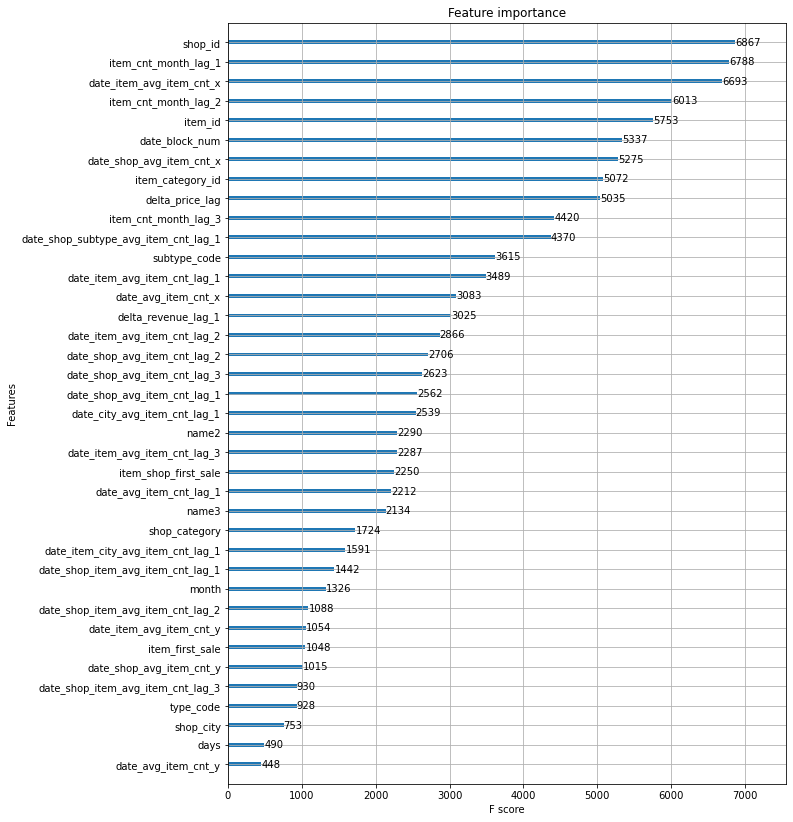

In [66]:
plot_features(model, (10,14))